<a href="https://colab.research.google.com/github/LaraN01/DrugData_AdverseEvents/blob/main/Notebook_4_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import the libraries

In [ ]:
import os
default_n_threads = 8
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['MKL_NUM_THREADS'] = f"{default_n_threads}"
os.environ['OMP_NUM_THREADS'] = f"{default_n_threads}"


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import joblib
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline


# 2. Load the data

In [ ]:
# # To activate when running on colab:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# dataset_path = '/content/drive/MyDrive/CAS_2023/final_dataset.csv'
#dataset_path = r"C:\Users\herzr\Desktop\Gitignore\final_dataset.csv"
dataset_path='datasets/final_dataset.csv'

In [ ]:
data=pd.read_csv(dataset_path,index_col=0, dtype={
    'UNII Codes for Inactive Ingredients':'O',
    'UNII Codes for Active Ingredients':'O',
    'Routes of Administration':'O',
    'Product Types':'O',
    'charge':'f4',
    'count':'f4',
    'stereochemistry':'O',
    'defined_stereo':'f4',
    'ez_centers':'f4',
    'molecular_weight':'f4',
    'optical_activity':'O',
    'stereo_centers':'f4',
    'patientsex':'O',
    'risk score':'f4'} )

# 3. Prepare the dataset

There is three product types: 'HUMAN PRESCRIPTION DRUG', 'HUMAN OTC DRUG', 'CELLULAR THERAPY'.
To select a different one change the target entry in the corresponing field of the loading function below.

Route of administration has as well fifferent options: 'PARENTERAL', 'TOPICAL', 'UROGENITAL', 'ORAL' and 'RESPIRATORY (INHALATION)'. To select the desired one for the training and ML just change the entry in the corresponding field below.

In [ ]:
def drugs_dataset(data):
    # Select the product type subcategory and route of aministration subcategory as applicable
    data_human=data[data['Product Types']=='HUMAN PRESCRIPTION DRUG']
    data_human_parenteral=data_human[data_human['Routes of Administration']=='ORAL']

    # For now removed also patientsex, we may add it again to see if it plays a role
    # Defined_stereo is always identical to stereo_centers, therefore one of the two was removed
    result=data_human_parenteral.drop(['Routes of Administration','Product Types','defined_stereo','patientsex'], axis=1)

    return result

In [ ]:
drugs=drugs_dataset(data)

# 4. General evaluation (shape, info, describe, distribution)

In [ ]:
drugs.head(5)

,UNII Codes for Inactive Ingredients,UNII Codes for Active Ingredients,charge,count,stereochemistry,ez_centers,molecular_weight,optical_activity,stereo_centers,risk score
14,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,7.0
15,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,7.0
16,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,7.0
17,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,9.0
18,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,7.0


In [ ]:
drugs.shape

(6185763, 10)

In [ ]:
drugs=drugs.drop_duplicates()

In [ ]:
drugs.shape

(10333, 10)

In [ ]:
drugs.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 10333 entries, 14 to 9224407
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   UNII Codes for Inactive Ingredients  10333 non-null  object 
 1   UNII Codes for Active Ingredients    10333 non-null  object 
 2   charge                               10333 non-null  float32
 3   count                                10333 non-null  float32
 4   stereochemistry                      10333 non-null  object 
 5   ez_centers                           10333 non-null  float32
 6   molecular_weight                     10333 non-null  float32
 7   optical_activity                     10333 non-null  object 
 8   stereo_centers                       10333 non-null  float32
 9   risk score                           10333 non-null  float32
dtypes: float32(6), object(4)
memory usage: 645.8+ KB


In [ ]:
drugs.describe()

,charge,count,ez_centers,molecular_weight,stereo_centers,risk score
count,10333.000000,10333.000000,10333.000000,10333.000000,10333.000000,10333.000000
mean,-0.014517,1.090874,0.142940,349.400085,1.699023,9.009774
std,0.342191,0.323261,0.611849,181.399506,2.909493,3.552521
min,-2.000000,1.000000,0.000000,18.015301,0.000000,3.000000
25%,0.000000,1.000000,0.000000,248.321304,0.000000,7.000000
50%,0.000000,1.000000,0.000000,335.466003,1.000000,9.000000
75%,0.000000,1.000000,0.000000,428.436005,2.000000,11.000000
max,3.000000,5.000000,5.000000,1462.717651,21.000000,15.000000


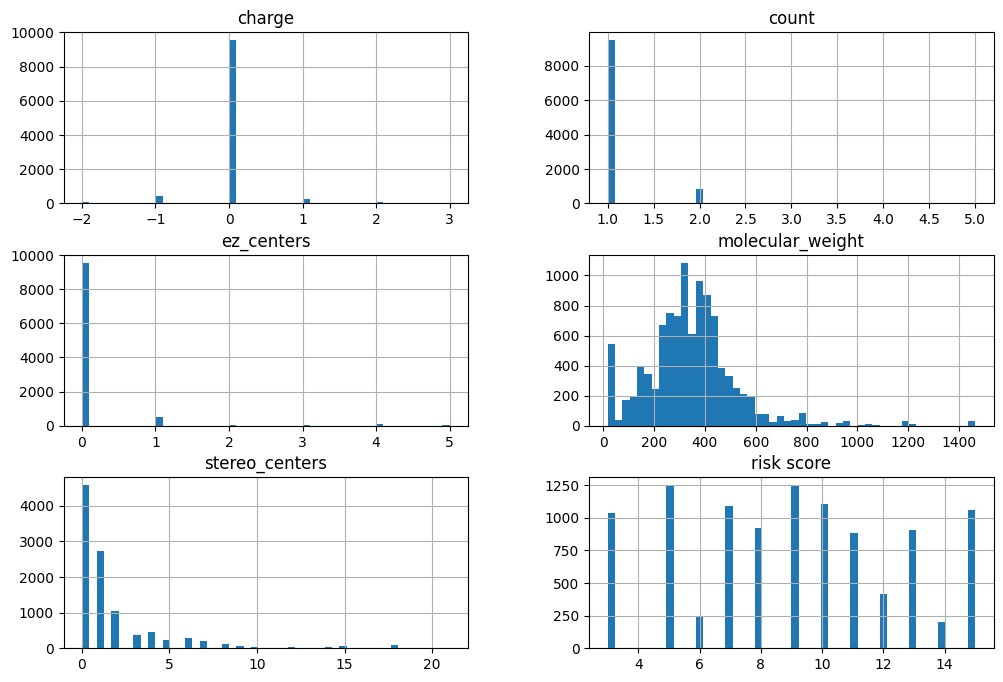

In [ ]:
drugs_num=drugs.select_dtypes(include=[np.number])
drugs_num.hist(bins=50, figsize=(12,8))
plt.show()

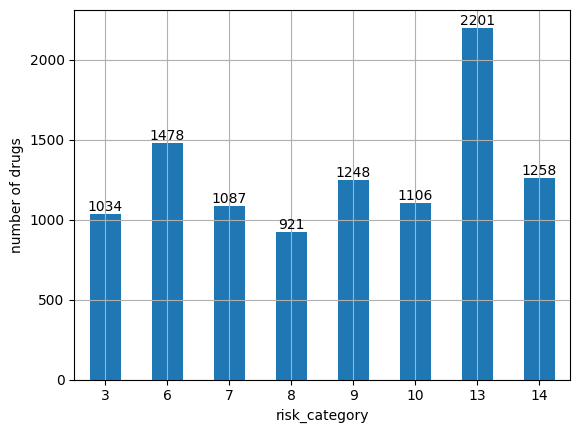

In [ ]:
drugs['risk_cat']=pd.cut(drugs['risk score'],
                         bins=[0,3,6,7,8,9,10,13,np.inf],
                         labels=[3,6,7,8,9,10,13,14])   # 3 is all <=3, 6 is 4-6, 13 is 11-13, 14 is >=14

risk_counts=drugs['risk_cat'].value_counts().sort_index()
ax=risk_counts.plot(kind='bar', rot=0, grid=True)
for i, v in enumerate(risk_counts):
    ax.text(i,v +0.1, str(v), ha='center', va='bottom')
plt.xlabel('risk_category')
plt.ylabel('number of drugs')
plt.show()

In [ ]:
# drugs['risk_cat']=pd.cut(drugs['risk score'],
#                          bins=[0,5,8,11,np.inf],
#                          labels=[5,8,11,13])   # 3 is all <=3, 6 is 4-6, 13 is 11-13, 14 is >=14

# risk_counts=drugs['risk_cat'].value_counts().sort_index()
# ax=risk_counts.plot(kind='bar', rot=0, grid=True)
# for i, v in enumerate(risk_counts):
#     ax.text(i,v +0.1, str(v), ha='center', va='bottom')
# plt.xlabel('risk_category')
# plt.ylabel('number of drugs')
# plt.show()

NOTE: ensure that all categories have >=2 entries, if not adapt the bins  
This is required for the stratified splitter

# 5. Train set, test set, validation set

## 5.1 Train set, test set

In [ ]:
splitter=StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(drugs, drugs['risk_cat']):
    strat_train_set=drugs.iloc[train_index]
    strat_test_set=drugs.iloc[test_index]

features=['UNII Codes for Inactive Ingredients',
          #'UNII Codes for Active Ingredients',
          #'charge',
          #'count',
          #'stereochemistry',
          #'ez_centers',
          'molecular_weight',
          #'optical_activity',
          #'stereo_centers',
          ]

target_feature='risk score'

X_train=strat_train_set[features]
y_train=strat_train_set[target_feature]
X_test=strat_test_set[features]
y_test=strat_test_set[target_feature]

In [ ]:
print('X train shape = ', X_train.shape)
print('X test shape = ', X_test.shape)

X train shape =  (8266, 2)
X test shape =  (2067, 2)


# 6. Feature scaling and transformation

## 6.1 Custom transformers

In [ ]:
class CustomMultilabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        #print("Fitting CustomMultilabelBinarizer...")
        X = self._apply_eval(X)
        #print("Evaluated input:", X)
        self.mlb.fit(X)
        self.known_classes_ = set(self.mlb.classes_)
        print("Known classes:", self.known_classes_)
        return self

    def transform(self, X):
        #print("Transforming with CustomMultilabelBinarizer...")
        X = self._apply_eval(X)
        #print("Evaluated input:", X)
        filtered_X = [
            [label for label in labels if label in self.known_classes_]
            for labels in X
        ]
        transformed_X = self.mlb.transform(filtered_X)
        #print("Transformed data:", transformed_X)
        return transformed_X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

    def _apply_eval(self, X):
        def safe_eval(x):
            try:
                result = x.split(', ') if isinstance(x, str) else x
                #print(f"Evaluating: {x} -> {result}")
                return result
            except Exception as e:
                #print(f"Error evaluating: {x} with error {e}")
                return []
        return [safe_eval(x) for x in X]


# NOTE: Un-comment the print checks only if needed for debugging/monitoring.
# With print statements require > 15GB RAM and cannot be saved (JSON string too long)

## 6.2 Pipelines and pre-processing

In [ ]:
cat_pipeline=make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore'))

mlb_pipeline=make_pipeline(
    CustomMultilabelBinarizer())

num_pipeline=make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    StandardScaler())

log_pipeline=make_pipeline(
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler())

cbrt_pipeline=make_pipeline(
    FunctionTransformer(np.cbrt, feature_names_out='one-to-one'),
    StandardScaler())

In [ ]:
preprocessor=ColumnTransformer([
    #('1H_encoded', cat_pipeline,['stereochemistry','optical_activity']),
    #('numericals', num_pipeline,['charge', 'count','ez_centers']),
    ('log_feat', log_pipeline, ['molecular_weight']),
    #('cbrt_feat', cbrt_pipeline, ['stereo_centers']),
    ('mlb', CustomMultilabelBinarizer(), 'UNII Codes for Inactive Ingredients'),
    #('ord_enc',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['UNII Codes for Active Ingredients'])
    ])


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [ ]:
pipeline.fit(X_train)

Known classes: {'A2M91M918C', '0I3V7S25AW', '0BZ5A00FQU', '2944357O2O', '5QWK665956', '059QF0KO0R', '2S7830E561', '11628IH70O', '30IQX730WE', '029TFK992N', 'Z4152N8IUI', 'G263MI44RU', 'I9O0E3H2ZE', 'K0KQV10C35', '4VON5FNS3C', '87Y6436BKR', 'ND2M416302', '7G1J5DA97F', '96K6UQ3ZD4', 'ZYD53NBL45', '0VUT3PMY82', '8LDD2V82F5', '949E52Z6MY', '4763AXI84L', '7LVU907546', 'SMD1X3XO9M', 'AB6MNQ6J6L', 'G2M7P15E5P', '3980JIH2SW', 'LKG8494WBH', 'C9H2L21V7U', '5TL50QU0W4', 'F8XAG1755S', '274KW0O50M', '506T60A25R', 'PNR0YF693Y', 'RV6J6604TK', 'OJ4Z5Z32L4', '40UAA97IT9', '161H3B14U2', '602HN5L69H', '368GB5141J', '68401960MK', 'CQ3XH3DET6', 'HM5Z15LEBN', 'H8AV0SQX4D', 'QU7E2XA9TG', '7CVR7L4A2D', '4GFU244C4J', '0WZ8WG20P6', 'XB09609XSL', '24SC3U704I', 'KH7I04HPUU', '97Z1WI3NDX', 'XF417D3PSL', '3SY5LH9PMK', '2A1Q1Q3557', 'AHQ60JKI5D', 'H3R47K3TBD', '15F1B5K9A5', 'XHX3C3X673', 'WAT0DDB505', '47MLB0F1MV', 'B1QE5P712K', 'Q504PL8E0V', '5Y0974F5PW', 'TM2TZD4G4A', 'S870P55O2W', '241ATL177A', '8VAB711C5E', 'A2I

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log_feat',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['molecular_weight']),
                                                 ('mlb',
                                                  CustomMultilabelBinarizer(),
                                                  'UNII Codes for Inactive '
                                                  'Ingredients')]))])

In [ ]:
X_train_preprocessed = pipeline.transform(X_train)

In [ ]:
X_test_preprocessed = pipeline.transform(X_test)

In [ ]:
print('Train set shape= ', X_train_preprocessed.shape)
print('Test set shape= ', X_test_preprocessed.shape)

Train set shape=  (8266, 426)
Test set shape=  (2067, 426)


In [ ]:
df_X_train_preprocessed=pd.DataFrame(X_train_preprocessed,
                                     columns=preprocessor.get_feature_names_out(),
                                     index=X_train.index)

df_X_test_preprocessed=pd.DataFrame(X_test_preprocessed,
                                    columns=preprocessor.get_feature_names_out(),
                                    index=X_test.index)

In [ ]:
# df_X_train_preprocessed.to_csv('/content/drive/MyDrive/CAS_2023/X_train_preprocessed.csv')
# df_X_test_preprocessed.to_csv('/content/drive/MyDrive/CAS_2023/X_test_preprocessed.csv')

In [ ]:
# y_train.to_csv('/content/drive/MyDrive/CAS_2023/y_train')
# y_test.to_csv('/content/drive/MyDrive/CAS_2023/y_test')

In [ ]:
df_X_train_preprocessed.head(5)

,log_feat__molecular_weight,mlb__029TFK992N,mlb__02F3473H9O,mlb__059QF0KO0R,mlb__05JZI7B19X,mlb__06XEA2VD56,mlb__07XHK4SAV6,mlb__0A7M0N7SPE,mlb__0BZ5A00FQU,mlb__0E53J927NA,...,mlb__Z0H242BBR1,mlb__Z4152N8IUI,mlb__Z78RG6M2N2,mlb__Z82Y2C65EA,mlb__Z8IX2SC1OH,mlb__Z944H5SN0H,mlb__ZF94AP8MEY,mlb__ZK64F7XSTX,mlb__ZT934N0X4W,mlb__ZYD53NBL45
1358037,0.599878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4023092,0.323513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4607745,-3.008324,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1231321,1.065470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807981,0.576984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_train.describe()

count    8266.000000
mean        9.011493
std         3.553717
min         3.000000
25%         7.000000
50%         9.000000
75%        11.000000
max        15.000000
Name: risk score, dtype: float64

In [ ]:
y_test.describe()

count    2067.000000
mean        9.002903
std         3.548583
min         3.000000
25%         7.000000
50%         9.000000
75%        11.000000
max        15.000000
Name: risk score, dtype: float64

# 7. Unsupervised learning

## 7.1 t-SNE

### 7.1.1 t-SNE only

In [ ]:
import multiprocessing

In [ ]:
tsne=TSNE(n_components=2, perplexity=50, learning_rate=250, n_iter=1500, random_state=42, n_jobs=-1, verbose=1)

In [ ]:
# Get the number of available CPU cores
num_cores = multiprocessing.cpu_count()
print(f"Number of available CPU cores: {num_cores}")

Number of available CPU cores: 4


In [ ]:
# Parameters for different t-SNE runs
# params = [
#     (sampled_X_train, 30, 200, 1000),
#     (sampled_X_train, 50, 250, 1500),
#     (sampled_X_train, 40, 300, 2000),
#     # Add more parameter combinations if needed
# ]

In [ ]:
# # Run t-SNE in parallel with verbosity
# results = Parallel(n_jobs=-1)(delayed(fit_tsne)(data, p, lr, ni) for data, p, lr, ni in params)

In [ ]:
X_tsne=tsne.fit_transform(X_train_preprocessed)

/home/lara/Documents/venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 8266 samples in 0.003s...


[t-SNE] Computed neighbors for 8266 samples in 1.576s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8266
[t-SNE] Computed conditional probabilities for sample 2000 / 8266
[t-SNE] Computed conditional probabilities for sample 3000 / 8266
[t-SNE] Computed conditional probabilities for sample 4000 / 8266
[t-SNE] Computed conditional probabilities for sample 5000 / 8266
[t-SNE] Computed conditional probabilities for sample 6000 / 8266
[t-SNE] Computed conditional probabilities for sample 7000 / 8266
[t-SNE] Computed conditional probabilities for sample 8000 / 8266
[t-SNE] Computed conditional probabilities for sample 8266 / 8266
[t-SNE] Mean sigma: 1.269641
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.710686
[t-SNE] KL divergence after 1500 iterations: -0.192520


In [ ]:
#sampled_y = y_train.iloc[indices] # Labels for the clusters (1-15 is our risk classes: same color = same class)

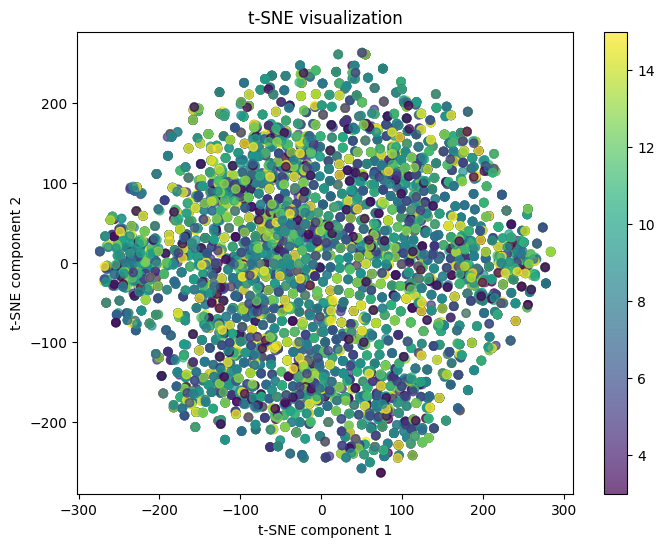

In [ ]:
t_SNE_only=plt.figure(figsize=(8, 6))
t_SNE_only_ax = t_SNE_only.add_subplot(111)
scatter_tsne = t_SNE_only_ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap=plt.get_cmap('viridis'), alpha=0.7)
t_SNE_only.colorbar(scatter_tsne)
t_SNE_only_ax.set_title('t-SNE visualization')
t_SNE_only_ax.set_xlabel('t-SNE component 1')
t_SNE_only_ax.set_ylabel('t-SNE component 2')
#t_SNE_only=plt.savefig('/content/drive/MyDrive/CAS_2023/240608_t_sne_only.png')
#t_SNE_only=plt.savefig('pictures/240610_t_sne_only.png')
plt.show()

The color gradient from purple (low risk) to yellow (high risk) represents the risk score of the drugs. Higher risk scores indicate drugs with more serious or adverse events.

Being the features the encoded inactive ingredients, if there are noticeable clusters of similar colors, this suggests that certain combinations of inactive ingredients might be associated with higher or lower risk scores. For example, a cluster of yellow points would indicate a group of drugs with similar high-risk inactive ingredients.  

The distribution of points can give insights into how inactive ingredients might contribute to the overall risk. Drugs with similar inactive ingredients (and thus similar binary features) tend to be closer together.

By examining the clusters with higher risk scores (yellow points), one could investigate the specific inactive ingredients present in these drugs. This might help in identifying which inactive ingredients or combinations thereof contribute to higher risks.

The overall circular pattern suggests a diverse dataset where no single group of inactive ingredients overwhelmingly dominates the risk score landscape.

In summary, this t-SNE visualization helps identify patterns and clusters of drugs based on their inactive ingredients and associated risk scores. High-risk clusters suggest combinations of inactive ingredients that might warrant further investigation for safety concerns.

#### 7.1.1.1 DBSCAN on t-SNE only results

In [ ]:
tsne_data = pd.DataFrame({
    'tsne1': X_tsne[:, 0],
    'tsne2': X_tsne[:, 1],
    'risk_score': y_train
})

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=10, min_samples=5)
clusters = dbscan.fit_predict(tsne_data[['tsne1', 'tsne2']])

tsne_data['cluster'] = clusters


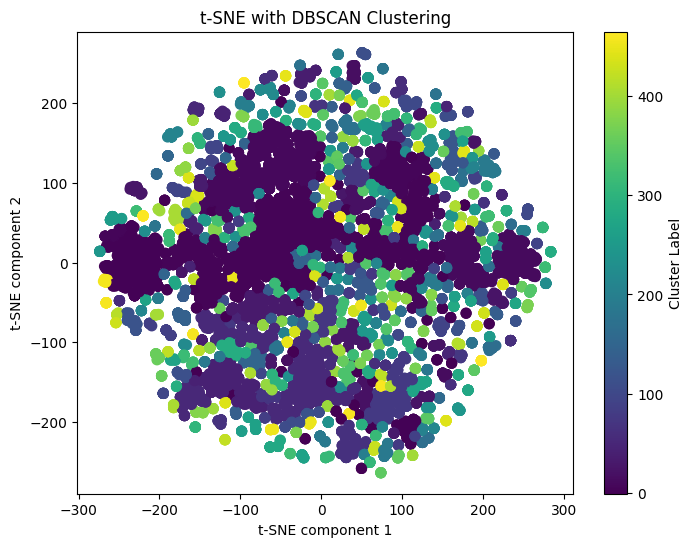

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_data['tsne1'], tsne_data['tsne2'], c=tsne_data['cluster'], cmap='viridis', s=50)
plt.colorbar(scatter, label='Cluster Label')
plt.title('t-SNE with DBSCAN Clustering')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

The output shows the t-SNE visualization with DBSCAN clustering applied.

Each color represents a different cluster label assigned by DBSCAN. Points with the same color belong to the same cluster.

The dark purple points (label 0) are classified as noise by DBSCAN. These points do not fit well into any cluster based on the `eps` and `min_samples` parameters. Areas with distinct colors (other than purple) indicate clusters of points that are close to each other in the high-dimensional space. The presence of multiple clusters suggests significant groupings within the data, potentially highlighting combinations of inactive ingredients associated with different risk scores.

Silhouette Score: -0.4945024251937866


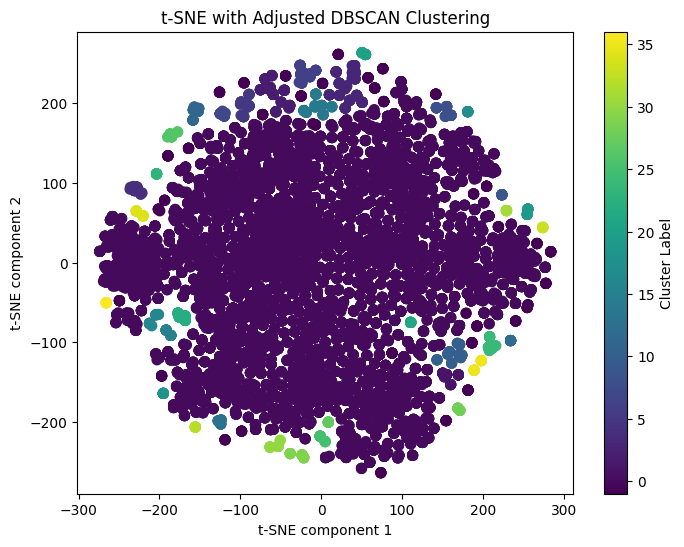

In [ ]:
from sklearn.metrics import silhouette_score

# Adjust DBSCAN parameters
dbscan = DBSCAN(eps=15, min_samples=10)  # Adjust these values as needed
clusters = dbscan.fit_predict(tsne_data[['tsne1', 'tsne2']])
tsne_data['cluster'] = clusters

# Calculate the silhouette score
sil_score = silhouette_score(tsne_data[['tsne1', 'tsne2']], tsne_data['cluster'])

# Print silhouette score
print(f'Silhouette Score: {sil_score}')

# Plotting the adjusted t-SNE results with DBSCAN clustering
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_data['tsne1'], tsne_data['tsne2'], c=tsne_data['cluster'], cmap='viridis', s=50)
plt.colorbar(scatter, label='Cluster Label')
plt.title('t-SNE with Adjusted DBSCAN Clustering')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()


A negative silhouette score indicates that the clustering is poor and that many points may be incorrectly assigned to clusters or marked as noise. This suggests that the current DBSCAN parameters may not be suitable for the data.

#### 7.1.1.2 K-means on t-SNE results

In [ ]:
from sklearn.cluster import KMeans

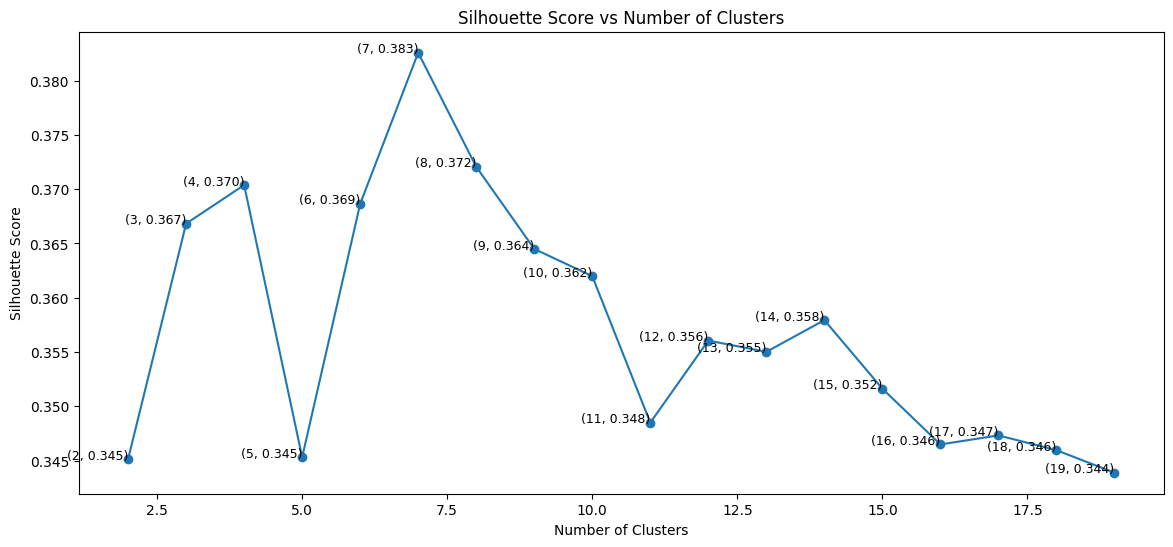

In [ ]:
# List to store silhouette scores for different numbers of clusters
sil_scores = []
k_range = range(2, 20)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42 )
    kmeans_clusters = kmeans.fit_predict(tsne_data[['tsne1', 'tsne2']])
    sil_score = silhouette_score(tsne_data[['tsne1', 'tsne2']], kmeans_clusters)
    sil_scores.append(sil_score)

plt.figure(figsize=(14, 6))
plt.plot(k_range, sil_scores, marker='o')

for i, score in enumerate(sil_scores):
    plt.text(k_range[i], score, f'({k_range[i]}, {score:.3f})', fontsize=9, ha='right')

# Plot the silhouette scores for different numbers of clusters
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

7 is the best number of clusters for an higher silhouette score

Silhouette Score for K-Means: 0.38256388902664185


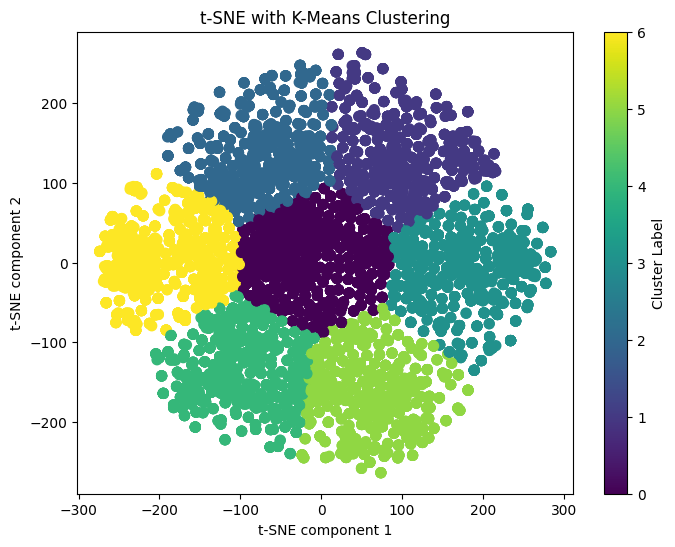

In [ ]:
from sklearn.cluster import KMeans

# Perform K-Means clustering
kmeans = KMeans(n_clusters=7, random_state=42)  # Choose an appropriate number of clusters
kmeans_clusters = kmeans.fit_predict(tsne_data[['tsne1', 'tsne2']])
tsne_data['kmeans_cluster'] = kmeans_clusters

# Calculate the silhouette score
sil_score_kmeans = silhouette_score(tsne_data[['tsne1', 'tsne2']], tsne_data['kmeans_cluster'])

# Print silhouette score
print(f'Silhouette Score for K-Means: {sil_score_kmeans}')

# Plotting the t-SNE results with K-Means clustering
plt.figure(figsize=(8, 6))
scatter_kmeans = plt.scatter(tsne_data['tsne1'], tsne_data['tsne2'], c=tsne_data['kmeans_cluster'], cmap='viridis', s=50)
plt.colorbar(scatter_kmeans, label='Cluster Label')
plt.title('t-SNE with K-Means Clustering')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()


The plot shows 7 distinct clusters, each represented by a different color.
Each color represents a different cluster, indicating that the drugs have been grouped into categories based on the similarity of their features (inactive ingredients). These clusters might help in identifying patterns or common characteristics among drugs within the same cluster.

#### 7.1.1.3 Analyze the obtained k-means clusters

   Cluster  Mean Risk Score  Std Risk Score  Count
0        0         9.094666        3.550503   1331
1        1         9.016750        3.533300   1194
2        2         9.000871        3.589314   1148
3        3         9.111728        3.575319   1262
4        4         8.913358        3.511715   1108
5        5         9.024597        3.554844   1179
6        6         8.879311        3.561915   1044


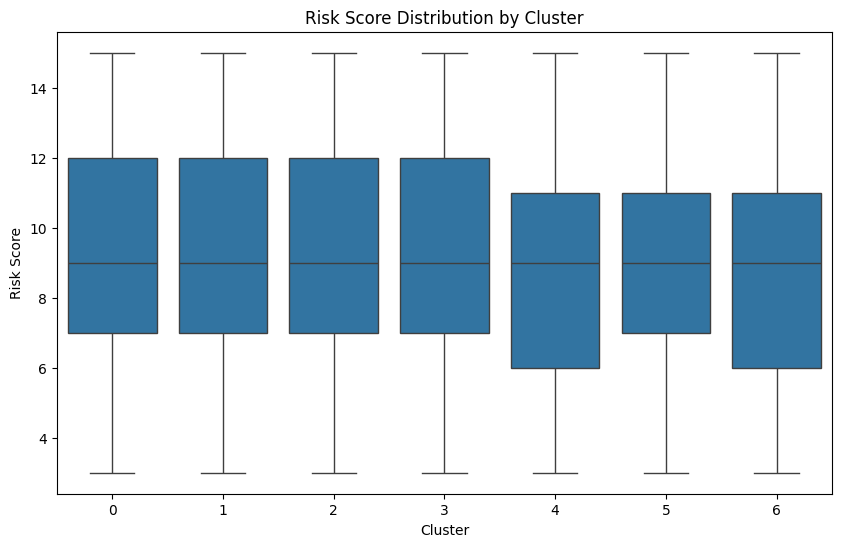

In [ ]:
# Group data by clusters
cluster_summary = tsne_data.groupby('kmeans_cluster').agg({
    'risk_score': ['mean', 'std', 'count']
}).reset_index()

cluster_summary.columns = ['Cluster', 'Mean Risk Score', 'Std Risk Score', 'Count']
print(cluster_summary)

# Visualize risk score distribution by cluster
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='kmeans_cluster', y='risk_score', data=tsne_data)
plt.title('Risk Score Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Risk Score')
plt.show()


The boxplot of risk score distribution by cluster provides valuable insights into how risk scores vary across different clusters.    Median Risk Score: the median risk score is similar across all clusters, around the 8-10 range. Cluster 4 and 6 appears to have a slightly lower median risk score compared to other clusters.

Overall Range: all clusters have a similar overall range of risk scores. This suggests that while there are distinct clusters based on inactive ingredients, the risk scores are broadly similar across these clusters.

#### 7.1.1.4 Analysis of the feature contribution: centroids

In [ ]:
df_X_train_preprocessed.index = tsne_data.index
merged_data = df_X_train_preprocessed.join(tsne_data[['tsne1', 'tsne2', 'risk_score', 'kmeans_cluster']])

# List the columns representing inactive ingredients
inactive_ingredients = [col for col in df_X_train_preprocessed.columns if col.startswith('mlb_')]

# Calculate the centroid of each cluster
centroids = merged_data.groupby('kmeans_cluster')[inactive_ingredients].mean()

# Identify top contributing features for each cluster
top_features_per_cluster = centroids.apply(lambda row: row.nlargest(5).index.tolist(), axis=1)

# Flatten the list and get unique features
top_features = list(set([item for sublist in top_features_per_cluster for item in sublist]))

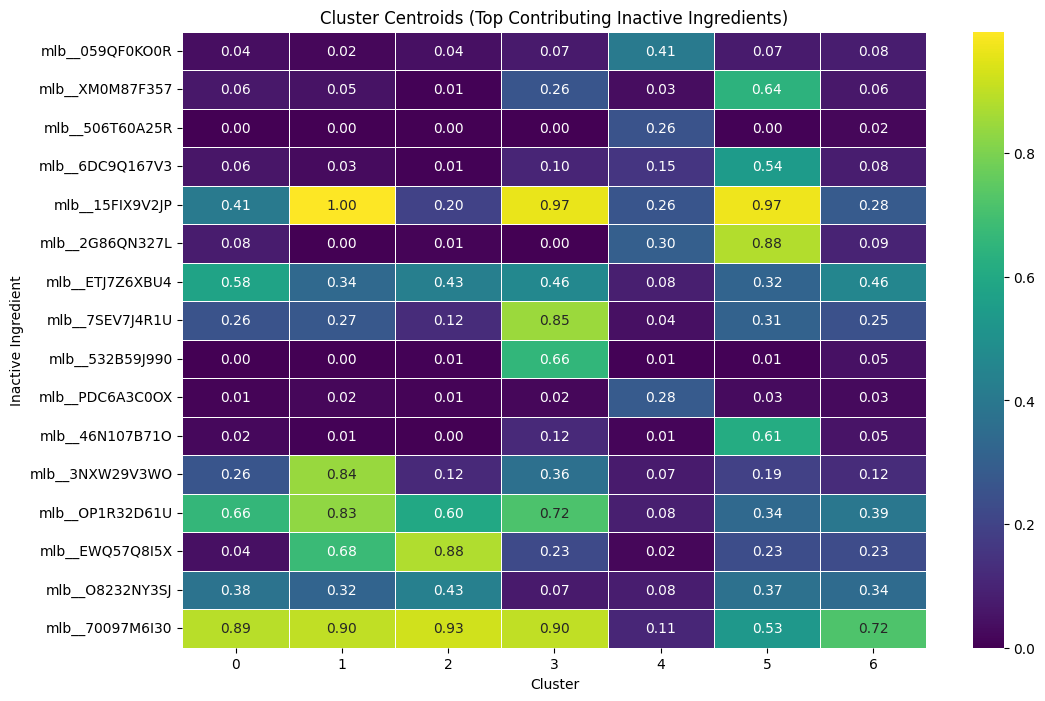

In [ ]:
# Filter centroids to include only top features
top_centroids = centroids[top_features]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_centroids.T, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Cluster Centroids (Top Contributing Inactive Ingredients)')
plt.xlabel('Cluster')
plt.ylabel('Inactive Ingredient')
plt.show()


Each row represents an inactive ingredient. The values in the heatmap indicate the mean presence (0 to 1) of the inactive ingredient in the drugs of each cluster. Each column represents a cluster identified by K-Means clustering. Clusters are shown in their original order.
The value of each cell indicates the mean presence of the corresponding inactive ingredient in that cluster. Higher values (closer to 1) indicate a higher presence of the ingredient in that cluster, while lower values (closer to 0) indicate a lower presence.  

Cluster-Specific Ingredients are clusters with high mean values for certain ingredients. For example, if Cluster 1 has a value of 1.00 for mlb__15FIX9V2JP, it indicates that this ingredient is highly present in the drugs belonging to Cluster 1.
Common Ingredients Across Cluster are instead ingredients with consistently high or low values across multiple clusters that might be common or rare across the dataset. For example, mlb__PDC6A3COOX has relatively low values across all clusters, indicating it's generally rare.
Unique Cluster Characteristics are unique ingredients that differentiate clusters them from others. For instance, mlb__7SEV7J4R1U has high values in Cluster 3 but low in others, it can be a distinguishing feature for Cluster 3.

Insights:

Cluster 1: Highly characterized by mlb__15FIX9V2JP, which has a value of 1.00.
Cluster 5: Characterized by high values for mlb__15FIX9V2JP and mlb__2G86QN327L.
Cluster 3: Has high values for mlb__15FIX9V2JP, mlb__7SEV7J4R1U and mlb__70097M6I30.
General Rarity: Ingredients like mlb__PDC6A3COOX and mlb__506T60A25R have generally low values across all clusters, indicating they are rarely present.
Widespread Ingredients: Ingredients like mlb__70097M6I30 and mlb__OP1R32D61U show significant presence in multiple clusters, indicating they are more common.

#### 7.1.1.5 Hyerarchical clustering on the centroids

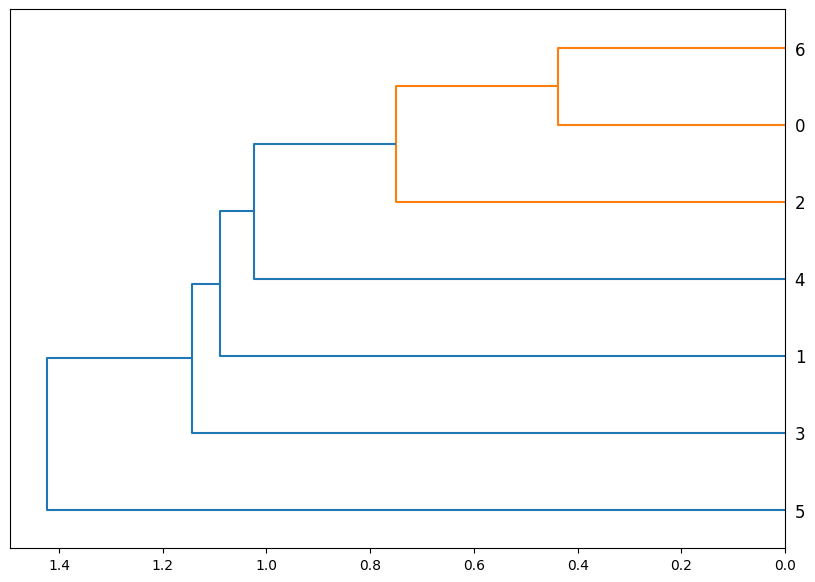

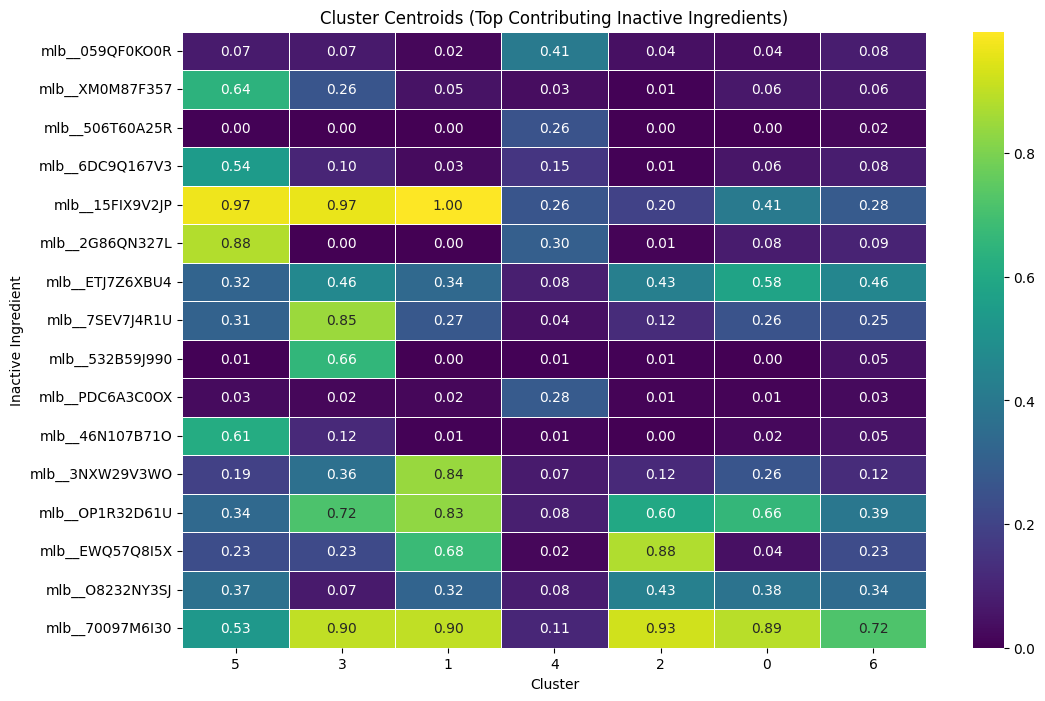

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform hierarchical clustering on centroids
linked = linkage(top_centroids, 'single')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=top_centroids.index, orientation='left')
plt.show()

# Reorder the centroids based on clustering
top_centroids = top_centroids.iloc[dendrogram(linked, no_plot=True)['leaves']]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_centroids.T, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Cluster Centroids (Top Contributing Inactive Ingredients)')
plt.xlabel('Cluster')
plt.ylabel('Inactive Ingredient')
plt.show()


**Dendrogram**:
The dendrogram shows the hierarchical relationships among the clusters. The horizontal axis represents the different clusters, and the vertical axis represents the distance or dissimilarity at which clusters are merged. Clusters that merge at lower heights are more similar.
Clusters 6 and 0 are very similar, as they merge at a relatively low distance.
Clusters 2, 4, 1, and 3 also show varying degrees of similarity, merging at different heights.

**Heatmap**:
Cluster 0 has high presence of mlb__ETJ7Z6XBU4 and mlb__EWQ57Q8I5X.
Cluster 2 is characterized by mlb_EWQ57Q8I5X with a notable presence of 0.88.
Cluster 1 is characterized by mlb__3NXW29V3WO with a high presence of 0.84.
Cluster 3 is notable for mlb__7SEV7J4R1U with a mean presence of 0.85.
Cluster 5 is highly characterized by mlb__15FIX9V2JP, with a mean presence of 1.00. Also has a high presence of mlb__6DC9Q167V3.
Cluster 6 is characterized by a significant presence of mlb__EWQ57Q8I5X.
Cluster 4 has high presence of mlb__70097M6I30 and mlb__OP1R32D61U.

Ingredients like mlb__OP1R32D61U and mlb__EWQ57Q8I5X are present in multiple clusters, indicating they are more common. in opposite, ingredients such as mlb__PDC6A3COOX and mlb__506T60A25R have low values across all clusters, indicating they are generally rare.
Some clusters share common ingredients, suggesting possible similarities in the formulation or characteristics of drugs in those clusters.
Clusters 6 and 0 share similar profiles, indicating that they have comparable inactive ingredient compositions.
Clusters 1 and 3 have distinct profiles, with high values for specific ingredients like mlb__3NXW29V3WO and mlb__7SEV7J4R1U, respectively.

#### 7.1.1.6 Hyerarchical clustering on columns and rows

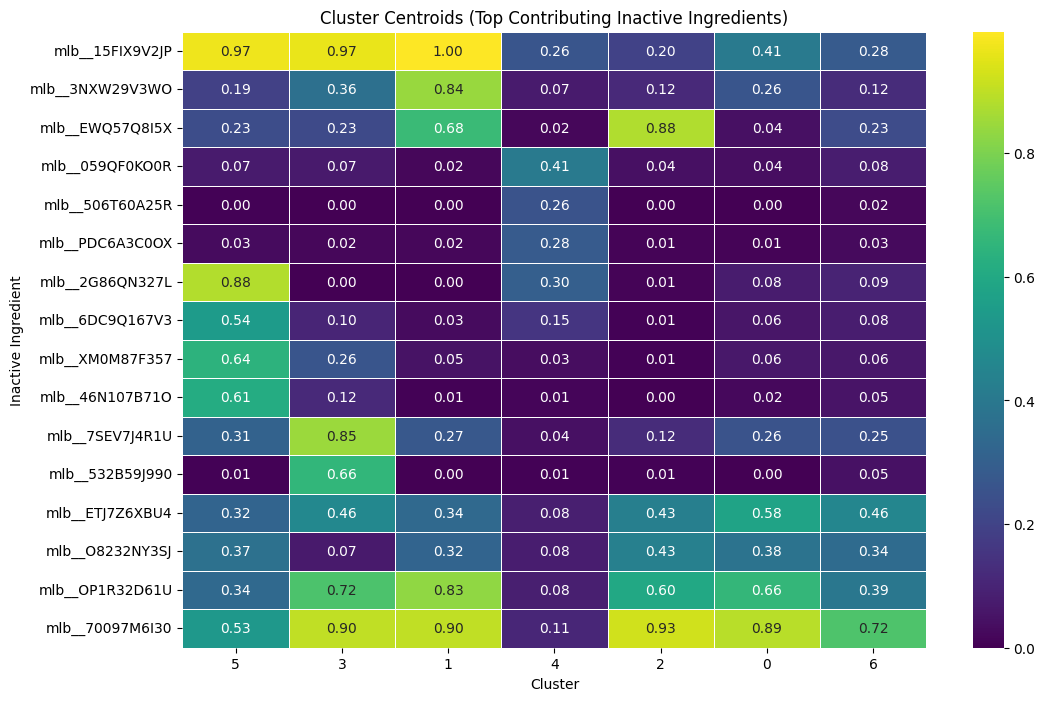

In [ ]:
# Perform hierarchical clustering on centroids
linked_rows = linkage(top_centroids, 'single')
linked_cols = linkage(top_centroids.T, 'single')

# Reorder the centroids based on clustering for both rows and columns
dendro_rows = dendrogram(linked_rows, no_plot=True)
dendro_cols = dendrogram(linked_cols, no_plot=True)

# Reorder rows and columns
reordered_centroids = top_centroids.iloc[dendro_rows['leaves'], :].iloc[:, dendro_cols['leaves']]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(reordered_centroids.T, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Cluster Centroids (Top Contributing Inactive Ingredients)')
plt.xlabel('Cluster')
plt.ylabel('Inactive Ingredient')
plt.show()


This heatmap shows the cluster centroids for the top contributing inactive ingredients, with both rows (inactive ingredients) and columns (clusters) reordered based on hierarchical clustering. Distribution and key findings are comparable with the discussion above.

#### 7.1.1.7 unsupervised learning with t-SNE conclusions

1. **Heatmap Insights**:
    - **Cluster-Specific Ingredients**: Certain clusters are characterized by specific inactive ingredients that are present in high concentrations. For example, Cluster 5 is dominated by `mlb__15FIX9V2JP`, while Cluster 1 has a high presence of `mlb__3NXW29V3WO`.
    - **Common Ingredients**: Some ingredients, like `mlb__OP1R32D61U` and `mlb__EWQ57Q8I5X`, are present across multiple clusters, indicating they are more common.
    - **Rare Ingredients**: Ingredients such as `mlb__PDC6A3COOX` and `mlb__506T60A25R` have generally low values across all clusters, indicating they are rare.

2. **Dendrogram Insights**:
    - The hierarchical clustering dendrogram groups similar clusters together, indicating that some clusters share similar inactive ingredient profiles. Clusters 6 and 0, for example, are very similar based on their low merge distance.

3. **Risk Score Distribution**:
    - The box plots of risk score distributions show that there is no significant difference in risk scores among the clusters. The median and spread of risk scores are fairly similar across all clusters, suggesting that the clustering based on inactive ingredients does not lead to a substantial difference in risk scores.

**General Conclusion:**

1. **Lack of Risk Score Differentiation**:
    - The clustering based on inactive ingredients did not result in significant differentiation in terms of risk scores. This suggests that inactive ingredients alone might not be the primary drivers of risk scores in the analyzed dataset.

2. **Potential Clustering by Formulation**:
    - The heatmaps reveal distinct clusters based on the presence of specific inactive ingredients, which could be indicative of different formulation strategies or categories of drugs. These clusters may represent different types or classes of drugs with similar formulations.

3. **Insight into Ingredient Usage**:
    - The analysis provides valuable insights into which inactive ingredients are commonly used together and which are unique to certain clusters. This information can be useful for understanding formulation practices and potentially for regulatory or quality control purposes.

4. **Further Analysis Needed**:
    - Since the risk scores do not vary significantly across the clusters, it may be beneficial to include other features in the clustering process. Active ingredients, dosage forms, therapeutic classes, or other relevant data might provide additional differentiation and insights into the factors driving risk scores.


#### 7.1.1.8 Feature importance with Random forest?

### 7.1.2 t-SNE on PCA output

In [ ]:
# Step 1: Reduce dimensions with PCA

pca = PCA(n_components=50)  # Reduce to 50 components or less
pca_result = pca.fit_transform(X_train_preprocessed)

In [ ]:
# Step 2: Apply t-SNE on the PCA-reduced data
X_tsne = tsne.fit_transform(pca_result)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 12764 samples in 0.002s...
[t-SNE] Computed neighbors for 12764 samples in 0.296s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12764
[t-SNE] Computed conditional probabilities for sample 2000 / 12764
[t-SNE] Computed conditional probabilities for sample 3000 / 12764
[t-SNE] Computed conditional probabilities for sample 4000 / 12764
[t-SNE] Computed conditional probabilities for sample 5000 / 12764
[t-SNE] Computed conditional probabilities for sample 6000 / 12764
[t-SNE] Computed conditional probabilities for sample 7000 / 12764
[t-SNE] Computed conditional probabilities for sample 8000 / 12764
[t-SNE] Computed conditional probabilities for sample 9000 / 12764
[t-SNE] Computed conditional probabilities for sample 10000 / 12764
[t-SNE] Computed conditional probabilities for sample 11000 / 12764
[t-SNE] Computed conditional probabilities for sample 12000 / 12764
[t-SNE] Computed conditional probabilities for sa

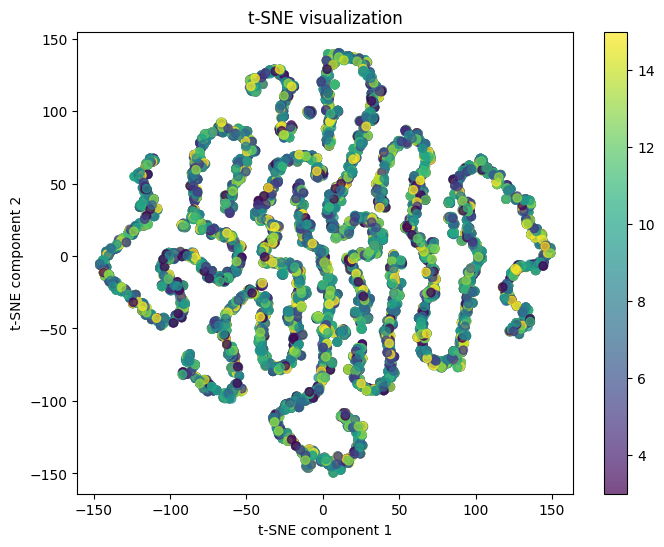

In [ ]:
# Step 3: Plot the results
labels=y_train
pca_tsne=plt.figure(figsize=(8, 6))
pca_tsne_ax=pca_tsne.add_subplot(111)
scatter_pca_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap=plt.get_cmap('viridis'), alpha=0.7)
pca_tsne.colorbar(scatter_pca_tsne)
pca_tsne_ax.set_title('t-SNE visualization')
pca_tsne_ax.set_xlabel('t-SNE component 1')
pca_tsne_ax.set_ylabel('t-SNE component 2')
pca_tsne=plt.savefig('/content/drive/MyDrive/CAS_2023/240608_pca_tsne.png')
plt.show()

The updated t-SNE visualization after applying PCA dimensionality reduction shows a similar winding structure to the initial visualization. Here are some additional insights:

- Preservation of Structure: The overall continuous, winding structure is preserved, indicating that the essential relationships and variations in the data are maintained even after applying PCA. This suggests PCA successfully retained the most significant features of the data before t-SNE was applied.

- Variations in Color Gradient: The color gradient still indicates another dimension of data, but the distribution appears slightly more uniform compared to the previous visualization. This might imply a slight reduction in noise or a better representation of the intrinsic data properties after PCA.

- Density and Continuity: The continuous nature of the data is reinforced. The density variations remain similar, with denser regions indicating higher concentrations of data points in the original space.

### 7.1.3 Comparison

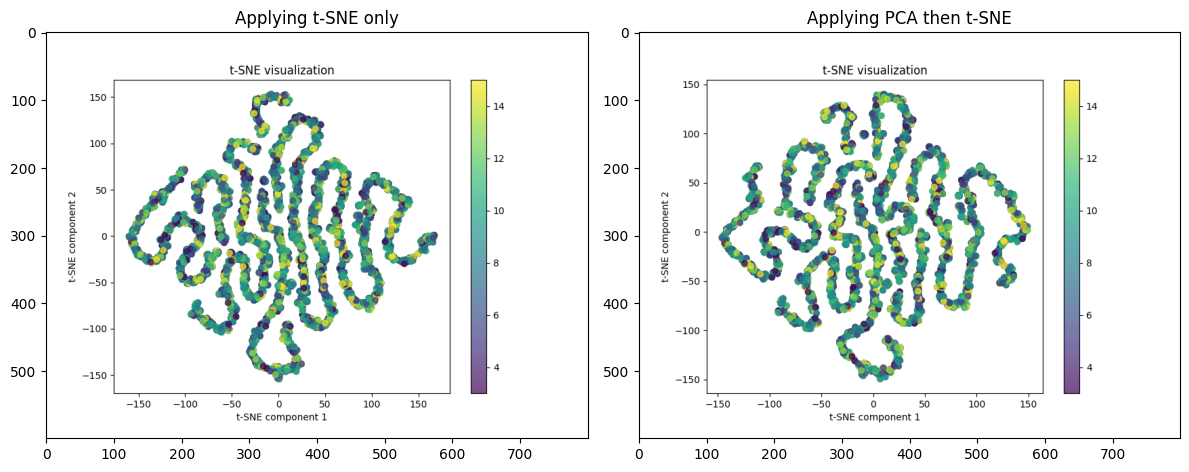

In [ ]:
t_SNE_only=np.asarray(Image.open('/content/drive/MyDrive/CAS_2023/240608_t_sne_only.png'))
pca_tsne=np.asarray(Image.open('/content/drive/MyDrive/CAS_2023/240608_pca_tsne.png'))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

axs[0].imshow(t_SNE_only)
axs[0].set_title('Applying t-SNE only')

axs[1].imshow(pca_tsne)
axs[1].set_title('Applying PCA then t-SNE')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CAS_2023/drop_dupl_t_sne_comparison.png')
plt.show()


Comparing with the initial t-SNE visualization without PCA, the structures are notably similar, but PCA might have helped in reducing the complexity or noise, making the overall pattern more discernible.

Conclusion:

Applying PCA before t-SNE can help in reducing noise and preserving essential features, making the visualization potentially clearer while maintaining the data's continuous structure. This approach is particularly useful when dealing with high-dimensional data to ensure more accurate and interpretable visualizations.


## 7.2 LLE

In [ ]:
import os

# Limit the number of threads used by OpenBLAS
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

In [ ]:
lle=LocallyLinearEmbedding(n_components=2,eigen_solver='dense', n_neighbors=10,n_jobs=1, random_state=42)
X_llembedded=lle.fit_transform(X_train_preprocessed)

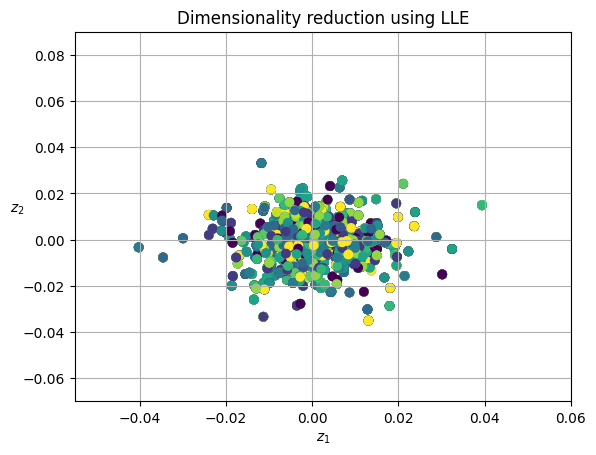

In [ ]:
plt.scatter(X_llembedded[:, 0], X_llembedded[:, 1],
            c=y_train, cmap='viridis')
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.savefig('/content/drive/MyDrive/CAS_2023/240608_lls.png')
plt.title("Dimensionality reduction using LLE")
plt.show()

The LLE (Locally Linear Embedding) representation in the given plot provides a different perspective compared to the t-SNE visualizations. Here are the key points for interpretation:

1. **Centralized Cluster**: The data points are concentrated around the origin with a relatively small spread, indicating that the LLE method has compressed the data into a dense cluster. This suggests that LLE has captured the local neighborhood relationships in a way that emphasizes similarities, resulting in a compact representation.

2. **Lack of Distinct Structure**: Unlike the t-SNE visualizations, there is no obvious continuous structure or distinct clusters. This can imply that LLE has emphasized local similarities at the expense of global structure, which is typical for LLE as it focuses on preserving local linear relationships.

3. **Color Distribution**: The color gradient, representing another dimension of data, appears to be randomly distributed. This might indicate that the LLE representation does not capture the variance in the data as effectively as t-SNE, or that the variance is more uniformly distributed in this local neighborhood representation.

4. **Dimensional Compression**: The range of values along both \( z_1 \) and \( z_2 \) axes is quite small, suggesting a strong compression of the high-dimensional data into a compact 2D space. This can be beneficial for certain types of data where local neighborhood information is crucial, but might lose some global structural information.

### Conclusion:
The LLE representation shows that the algorithm has compressed the data into a tight cluster, emphasizing local neighborhood relationships while possibly losing some of the global structure. This method is useful when local similarities are more important than the overall global layout, but it may not be as effective for visualizing large-scale structures and patterns in the data compared to t-SNE.

## 7.3 K-means

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
k=5
kmeans=KMeans(n_clusters=k, random_state=42, n_init=10)

In [ ]:
y_pred=kmeans.fit_predict(X_train_preprocessed)

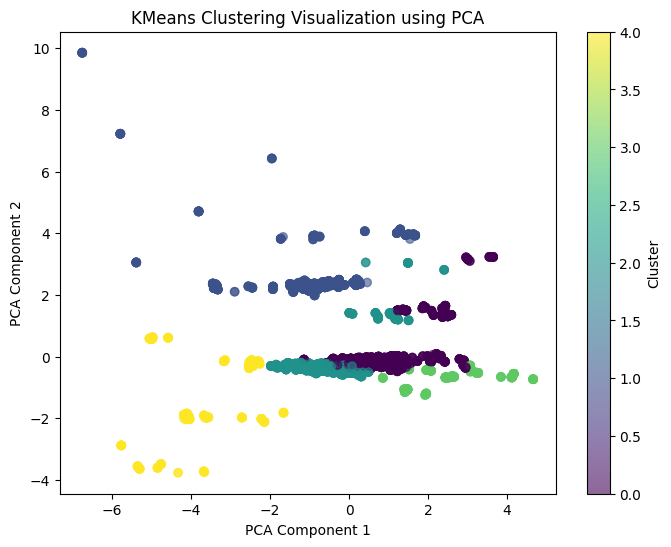

In [ ]:
# Use PCA for dimensionality reduction to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_preprocessed)

# Plot the clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clustering Visualization using PCA')
plt.show()


# 8. Supervised learning

## 8.1 Ensemble learning

In [ ]:
rnd_clf=RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                               n_jobs=-1, random_state=42, verbose=1)

In [ ]:
rnd_clf.fit(X_train_preprocessed, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.1s finished


RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42, verbose=1)

In [ ]:
y_train_pred_rf=cross_val_predict(rnd_clf, X_train_preprocessed, y_train, cv=10)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  

In [ ]:
for score, name in zip(rnd_clf.feature_importances_, df_X_train_preprocessed.columns):
    print(f"{round(score, 2)}: {name}")

0.01: numericals__charge
0.01: numericals__count
0.01: numericals__ez_centers
0.05: log_feat__molecular_weight
0.02: cbrt_feat__stereo_centers
0.0: mlb__029TFK992N
0.0: mlb__02F3473H9O
0.01: mlb__059QF0KO0R
0.0: mlb__05JZI7B19X
0.0: mlb__06XEA2VD56
0.0: mlb__07XHK4SAV6
0.0: mlb__0A7M0N7SPE
0.0: mlb__0BZ5A00FQU
0.0: mlb__0E53J927NA
0.0: mlb__0HO1H52958
0.0: mlb__0I3V7S25AW
0.0: mlb__0IRH2BR587
0.0: mlb__0MKJ04EU89
0.0: mlb__0UZA3422Q4
0.0: mlb__0VUT3PMY82
0.0: mlb__0WZ8WG20P6
0.0: mlb__0ZBX0N59RZ
0.0: mlb__10LGE70FSU
0.0: mlb__11628IH70O
0.0: mlb__1364PS73AF
0.0: mlb__14255EXE39
0.0: mlb__150CTM9A3J
0.0: mlb__15F1B5K9A5
0.01: mlb__15FIX9V2JP
0.0: mlb__161H3B14U2
0.0: mlb__1678RKX8RT
0.0: mlb__1699G8679Z
0.0: mlb__196OC77688
0.0: mlb__1CS02G8656
0.0: mlb__1DI56QDM62
0.0: mlb__1I96OHX6EK
0.0: mlb__1IVH67816N
0.01: mlb__1K09F3G675
0.0: mlb__1P9D0Z171K
0.01: mlb__1Q73Q2JULR
0.0: mlb__1T6N4D9YV6
0.0: mlb__1VPU26JZZ4
0.0: mlb__1Z74184RGV
0.0: mlb__2126FD486L
0.01: mlb__2165RE0K14
0.0: mlb__21

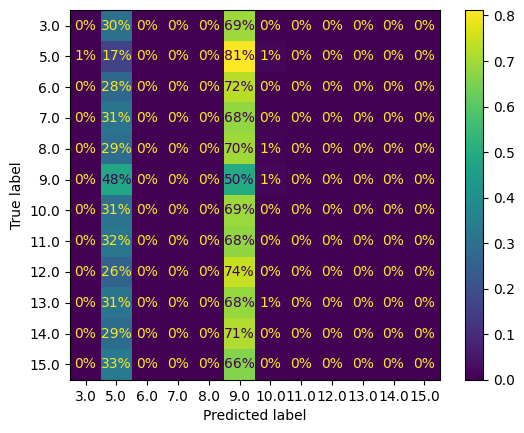

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_rf,
                                        normalize='true', values_format=".0%")
plt.show()

High Accuracy for Certain Classes: Some classes, such as 6 and 7, show high diagonal percentages (74% and 66%), indicating that the model performs well in predicting these classes.  
Misclassifications: Some classes have significant misclassifications. For example, class 3 is often misclassified as class 5 (34%), and class 9 as class 8 (25%).  
Zero Predictions: Certain classes have zero predictions for many other classes, indicating that the model did not predict these classes at all.

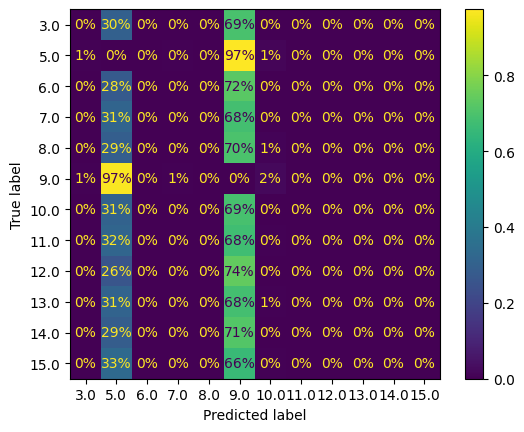

In [ ]:
sample_weight=(y_train_pred_rf != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_rf,
                                        sample_weight=sample_weight,
                                        normalize='true', values_format=".0%")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_leaf_nodes': [10, 16, 20, 30],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestClassifier
rnd_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform grid search
grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_preprocessed, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train_preprocessed, y_train)

# Predict with the best model
y_pred_opt = best_model.predict(X_train_preprocessed)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters: {'max_depth': None, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


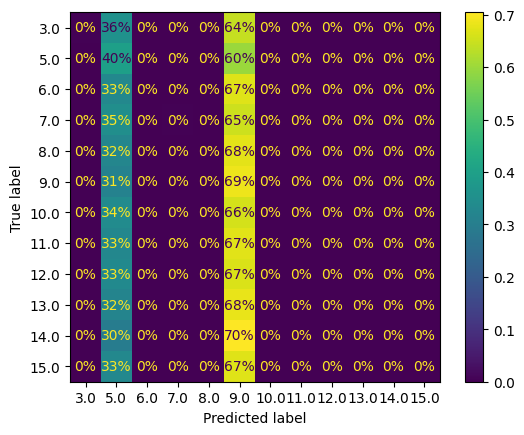

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_opt,
                                        normalize='true', values_format=".0%")
plt.show()

## 8.2 Stacking

In [ ]:
# For now do not run this cell
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [ ]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb

In [ ]:
# Define the base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
]

# Define the meta-model
meta_model = LogisticRegression()

# Create the stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Train the stacking classifier
stacking_clf.fit(X_train_preprocessed, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_leaf_nodes=16,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None, g...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('svm', SVC(probability=True, random_state=42))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [ ]:
# Predict using the stacking classifier
y_pred_train = stacking_clf.predict(X_train_preprocessed)

# Evaluate the stacking classifier
accuracy = accuracy_score(y_train, y_pred_train)
conf_matrix = confusion_matrix(y_train, y_pred_train)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.04677217173299906
Confusion Matrix:
 [[ 18 428   0 117  22 359 141  23   0  37   0 119]
 [161 318   0 168  33 512 181  27   0  51   0 162]
 [ 14  59   0  24   4  78  32   7   0  15   0  28]
 [119 449   0   4  27 378 164  25   0  52   0 133]
 [ 78 321   0 101   0 311 114  19   0  45   0 102]
 [150 588   0 170  34 238 193  30   0  51   0 165]
 [115 473   0 130  35 402  15  25   0  52   0 139]
 [ 75 333   0 109  22 303 111   0   0  41   0  92]
 [ 35 134   0  47   9 128  39   5   0  23   0  41]
 [ 89 343   0 105  21 306 124  21   0   0   0  95]
 [ 23  65   0  18   4  58  21   1   0  11   0  26]
 [105 432   0 139  33 365 148  26   0  49   0   4]]


In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train,
                                        normalize='true', values_format=".0%")
plt.show()

In [ ]:
X_train_preprocessed.shape

(12764, 697)

In [ ]:
X_test_preprocessed.shape

(3191, 697)

In [ ]:
# Predict using the stacking classifier
y_pred_test = stacking_clf.predict(X_test_preprocessed)

# Evaluate the stacking classifier
accuracy = accuracy_score(y_test, y_pred_test)

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,
                                        normalize='true', values_format=".0%")
plt.show()

## 8.3 Stacking on k-means clusters

In [ ]:
# Perform KMeans clustering
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
y_pred_clusters = kmeans.fit_predict(X_train_preprocessed)

In [ ]:
# Append the cluster assignments as a new feature to the original dataset
X_train_with_clusters = np.hstack((X_train_preprocessed, y_pred_clusters.reshape(-1, 1)))

In [ ]:
# Define the base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
]

# Define the meta-model
meta_model = LogisticRegression()

# Create the stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Train the stacking classifier
stacking_clf.fit(X_train_with_clusters, y_train)

# Predict using the stacking classifier
y_pred_train = stacking_clf.predict(X_train_with_clusters)


In [ ]:
# Evaluate the stacking classifier
accuracy = accuracy_score(y_train, y_pred_train)
conf_matrix = confusion_matrix(y_train, y_pred_train)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.04544030084612974
Confusion Matrix:
 [[  9 420   0 134  20 363 133  28   0  41   0 116]
 [162 301   0 179  28 500 186  39   0  58   0 160]
 [ 17  51   0  32   3  80  31   9   0  15   0  23]
 [116 430   0  13  25 371 164  38   0  56   0 138]
 [ 85 308   0 110   0 303 110  31   0  43   0 101]
 [161 562   0 189  32 228 195  41   0  55   0 156]
 [131 449   0 146  31 387  23  36   0  52   0 131]
 [ 81 318   0 118  23 291 114   0   0  45   0  96]
 [ 33 127   0  49   8 123  43   9   0  23   0  46]
 [ 89 321   0 121  19 301 125  32   0   0   0  96]
 [ 19  69   0  22   2  57  16   1   0  11   0  30]
 [111 403   0 146  29 362 147  41   0  56   0   6]]


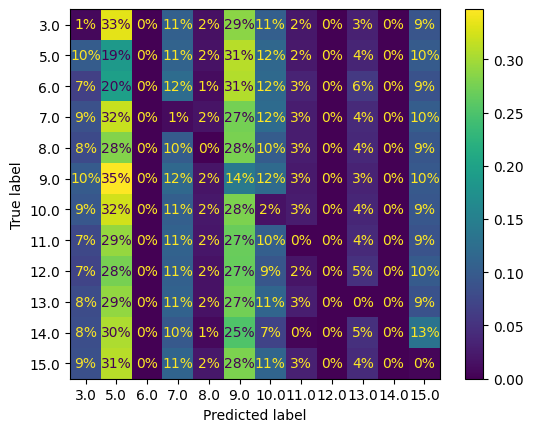

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train,
                                        normalize='true', values_format=".0%")
plt.show()

In [ ]:
# Predict clusters for the test set using the trained KMeans model
y_test_clusters = kmeans.predict(X_test_preprocessed)

# Append the cluster assignments as a new feature to the test dataset
X_test_with_clusters = np.hstack((X_test_preprocessed, y_test_clusters.reshape(-1, 1)))

# Predict using the trained stacking classifier
y_pred_test = stacking_clf.predict(X_test_with_clusters)

# Evaluate the stacking classifier on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print("Test Accuracy:", accuracy_test)
print("Test Confusion Matrix:\n", conf_matrix_test)


Test Accuracy: 0.3071137574428079
Test Confusion Matrix:
 [[ 60  61   0  29   3  73  36   6   0  16   0  32]
 [ 20 242   0  36   2  54  23   5   0   5   0  19]
 [  2  17   0   7   1  21   3   2   0   2   0   7]
 [ 17  89   0 118   6  62  18   5   0   6   0  17]
 [ 14  91   0  24  18  68  27   4   0   9   0  18]
 [ 22  57   0  36   2 244  12   4   0   9   0  19]
 [ 14  79   0  25   2  63 129   7   0   7   0  20]
 [ 22  82   0  18   6  64  33  24   0   7   0  17]
 [  8  34   0   7   3  41  10   3   0   7   0  12]
 [ 15  78   0  21   7  66  22   7   0  37   0  12]
 [  6  14   0   7   1  12  11   1   0   0   0   8]
 [ 23  78   0  20   3  67  17   4   0   2   0 108]]


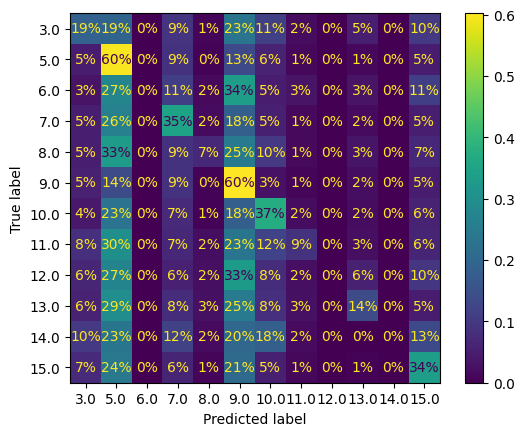

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,
                                        normalize='true', values_format=".0%")
plt.show()

## 8.4 Stacking on k-means result, reduced by PCA

In [ ]:
# Perform KMeans clustering
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
y_pred_clusters = kmeans.fit_predict(X_train_preprocessed)

# Append the cluster assignments as a new feature to the original dataset
X_train_with_clusters = np.hstack((X_train_preprocessed, y_pred_clusters.reshape(-1, 1)))

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95, random_state=42)  # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train_with_clusters)

In [ ]:
# Define the base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
]

# Define the meta-model
meta_model = LogisticRegression()

# Create the stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Train the stacking classifier
stacking_clf.fit(X_train_pca, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_leaf_nodes=16,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None, g...
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('svm', SVC(probability=True, random_state=42))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [ ]:
# Predict using the stacking classifier
y_pred_train = stacking_clf.predict(X_train_pca)

# Evaluate the stacking classifier
accuracy = accuracy_score(y_train, y_pred_train)
conf_matrix = confusion_matrix(y_train, y_pred_train)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.09471952366029458
Confusion Matrix:
 [[  5 520   0  93   0 463 111   0   0   0   0  72]
 [ 24 558   0 150   0 634 143   0   0   0   0 104]
 [  3 113   0  21   0  92  24   0   0   0   0   8]
 [ 15 573   0  59   0 516 113   0   0   0   0  75]
 [ 12 455   0  85   0 391  95   0   0   0   0  53]
 [ 24 732   0 137   0 485 149   0   0   0   0  92]
 [ 17 595   0 114   0 525  68   0   0   0   0  67]
 [ 10 457   0  88   0 404  84   0   0   0   0  43]
 [  4 204   0  30   0 159  40   0   0   0   0  24]
 [ 13 455   0  83   0 413 100   0   0   0   0  40]
 [  0  95   0  22   0  83  15   0   0   0   0  12]
 [ 16 542   0 102   0 497 110   0   0   0   0  34]]


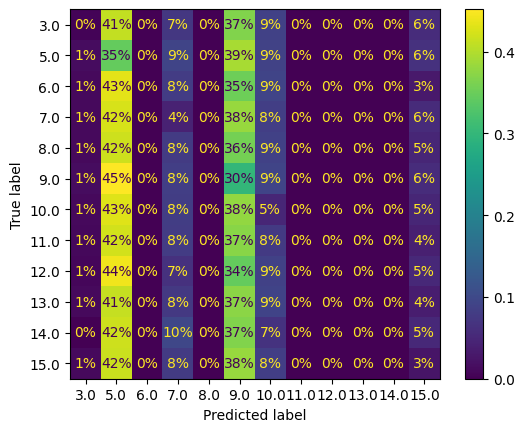

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train,
                                        normalize='true', values_format=".0%")
plt.show()

# 9. Neural Networks

In [ ]:
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## 9.1 Fully connected neural network

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

unique_labels_encoded = np.unique(y_train_encoded)
print("Unique labels after encoding in y_train:", unique_labels_encoded)

Unique labels after encoding in y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels_encoded, y=y_train_encoded)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: 0.8415084388185654, 1: 0.6594337673072949, 2: 4.075351213282247, 3: 0.7873180360226992, 4: 0.974946532233425, 5: 0.6569899114679844, 6: 0.7674362674362675, 7: 0.9794352363413137, 8: 2.307302964569776, 9: 0.9634661835748792, 10: 4.68575624082232, 11: 0.8175762234178837}


In [ ]:
# Verifications
print("Unique labels in y_train_encoded:", np.unique(y_train_encoded))
print("Unique labels in y_test_encoded:", np.unique(y_test_encoded))
print("X_train_preprocessed shape:", X_train_preprocessed.shape)
print("y_train_encoded shape:", y_train_encoded.shape)
print("X_test_preprocessed shape:", X_test_preprocessed.shape)
print("y_test_encoded shape:", y_test_encoded.shape)

Unique labels in y_train_encoded: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Unique labels in y_test_encoded: [ 0  1  2  3  4  5  6  7  8  9 10 11]
X_train_preprocessed shape: (12764, 697)
y_train_encoded shape: (12764,)
X_test_preprocessed shape: (3191, 697)
y_test_encoded shape: (3191,)


In [ ]:
model=tf.keras.Sequential([
    tf.keras.layers.Dense(300, activation='relu', input_shape=(697,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')  # 13 possible classes from 3 to 15
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               209400    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 12)                1212      
                                                                 
Total params: 240712 (940.28 KB)
Trainable params: 240712 (940.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_preprocessed, y_train_encoded, epochs=30,
                    validation_data=(X_test_preprocessed, y_test_encoded),
                    class_weight=class_weights_dict,
                    batch_size=128)

Epoch 1/30
100/100 [==============================] - 1s 7ms/step - loss: 101.5815 - accuracy: 0.0765 - val_loss: 3.0498 - val_accuracy: 0.0216
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 2.5306 - accuracy: 0.0900 - val_loss: 3.0473 - val_accuracy: 0.0207
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - loss: 2.4869 - accuracy: 0.0588 - val_loss: 3.0478 - val_accuracy: 0.0210
Epoch 4/30
100/100 [==============================] - 0s 5ms/step - loss: 2.4854 - accuracy: 0.0874 - val_loss: 3.0482 - val_accuracy: 0.0207
Epoch 5/30
100/100 [==============================] - 0s 5ms/step - loss: 2.4852 - accuracy: 0.1084 - val_loss: 3.0490 - val_accuracy: 0.0210
Epoch 6/30
100/100 [==============================] - 0s 5ms/step - loss: 2.4851 - accuracy: 0.0546 - val_loss: 3.0489 - val_accuracy: 0.0204
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - loss: 2.4851 - accuracy: 0.0264 - val_loss: 3.0484 - val_accuracy: 0.0197
Epoc

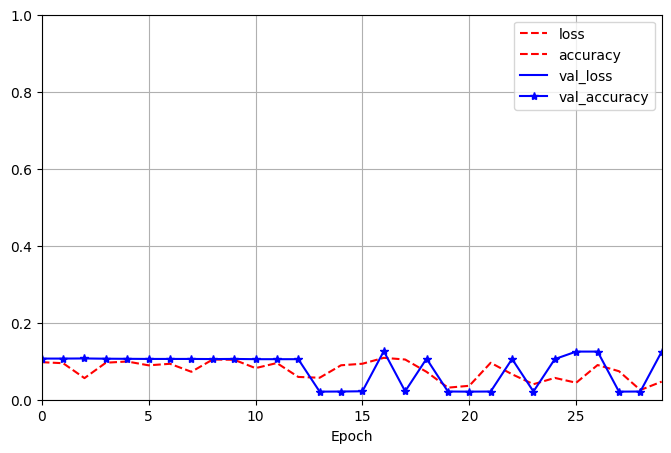

In [ ]:
pd.DataFrame(history.history).plot(
    figsize=(8,5), xlim=[0,29], ylim=[0,1], grid=True, xlabel='Epoch',
    style=['r--', 'r--', 'b-', 'b-*'])
plt.show()

## 9.2 Fully connected neural network with regularization and hyperparameter tuning

In [ ]:
model_reg=tf.keras.Sequential([
    tf.keras.layers.Dense(128,input_dim=X_train_preprocessed.shape[1], activation='relu',),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')  # 13 possible classes from 3 to 15
])

In [ ]:
model_reg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               89344     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 12)                396       
                                                                 
Total params: 100076 (390.92 KB)
Trainable params: 100076 (390.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
optimizer=Adam(learning_rate=0.001)
model_reg.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model
history_reg = model_reg.fit(
    X_train_preprocessed, y_train_encoded,
    epochs=100,
    validation_data=(X_test_preprocessed, y_test_encoded),
    batch_size=256,
    callbacks=[early_stopping]
)


Epoch 1/100
50/50 [==============================] - 1s 10ms/step - loss: 8.4812 - accuracy: 0.0942 - val_loss: nan - val_accuracy: 0.1012
Epoch 2/100
50/50 [==============================] - 0s 6ms/step - loss: 2.4638 - accuracy: 0.1134 - val_loss: nan - val_accuracy: 0.1250
Epoch 3/100
50/50 [==============================] - 0s 6ms/step - loss: 2.4396 - accuracy: 0.1220 - val_loss: nan - val_accuracy: 0.1260
Epoch 4/100
50/50 [==============================] - 0s 6ms/step - loss: 2.4213 - accuracy: 0.1307 - val_loss: nan - val_accuracy: 0.1244
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: 2.4074 - accuracy: 0.1221 - val_loss: nan - val_accuracy: 0.1238
Epoch 6/100
50/50 [==============================] - 0s 6ms/step - loss: 2.4002 - accuracy: 0.1284 - val_loss: nan - val_accuracy: 0.1254
Epoch 7/100
50/50 [==============================] - 0s 6ms/step - loss: 2.3882 - accuracy: 0.1279 - val_loss: nan - val_accuracy: 0.1263
Epoch 8/100
50/50 [==============

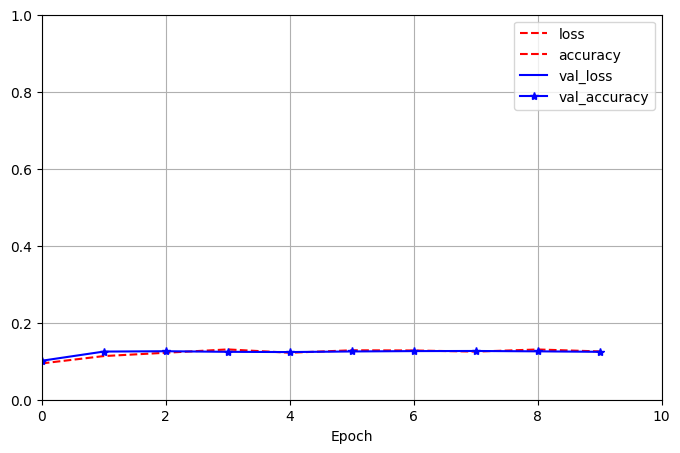

In [ ]:
pd.DataFrame(history_reg.history).plot(
    figsize=(8,5), xlim=[0,10], ylim=[0,1], grid=True, xlabel='Epoch',
    style=['r--', 'r--', 'b-', 'b-*'])
plt.show()

Possible next steps:  
- Improve the stacking through grid search